In [1]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Tensorflow_helper import choose_gpu_by_id
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)
# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# ------------------------------------------ import helpers
# this should import glob, os, and many other standard libs
from src.utils.Notebook_imports import *
from tensorflow.python.client import device_lib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
# local imports
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D
from src.utils.KerasCallbacks import get_callbacks

# import external libs
import cv2
import pandas as pd

EXPERIMENT = 'temp/Bi-LSTM_CCE_minus5_5phaseaug_NOaug'
timestemp = str(datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")) # ad a timestep to each project to make repeated experiments unique

MODEL_PATH = os.path.join('models', EXPERIMENT, timestemp)
TENSORBOARD_LOG_DIR = os.path.join('reports/tensorboard_logs', EXPERIMENT,timestemp)
CONFIG_PATH = os.path.join('reports/configs/',EXPERIMENT,timestemp)
HISTORY_PATH = os.path.join('reports/history/',EXPERIMENT,timestemp)
SAVE_LEARNING_PROGRESS_AS_TF = True

# General params
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 4 # 32, 64, 24, 16, 1 for 3D use: 4
GENERATOR_WORKER = BATCHSIZE # if not set, use batchsize

DIM = [8, 64, 64] # network input params for spacing of 3, (z,y,x)
T_SHAPE = 36
SPACING = [8, 3, 3] # if resample, resample to this spacing, (z,y,x)

# Model params
DEPTH = 3 # depth of the encoder
FILTERS = 32 # initial number of filters, will be doubled after each downsampling block
M_POOL = [1, 2, 2]# size of max-pooling used for downsampling and upsampling
F_SIZE = [3, 3, 3] # conv filter size
BN_FIRST = False # decide if batch normalisation between conv and activation or afterwards
BATCH_NORMALISATION = True # apply BN or not
PAD = 'same' # padding strategy of the conv layers
KERNEL_INIT = 'he_normal' # conv weight initialisation
OPTIMIZER = 'adam' # Adam, Adagrad, RMSprop, Adadelta,  # https://keras.io/optimizers/
ACTIVATION = 'relu' # tf.keras.layers.LeakyReLU(), relu or any other non linear activation function
LEARNING_RATE = 1e-4 # start with a huge lr to converge fast
DECAY_FACTOR = 0.3 # Define a learning rate decay for the ReduceLROnPlateau callback
MIN_LR = 1e-10 # minimal lr, smaller lr does not improve the model
DROPOUT_min = 0.3 # lower dropout at the shallow layers
DROPOUT_max = 0.5 # higher dropout at the deep layers

# Augmentation and Generator params
BORDER_MODE = cv2.BORDER_REFLECT_101 # border mode for the data generation
IMG_INTERPOLATION = cv2.INTER_LINEAR # image interpolation in the genarator
MSK_INTERPOLATION = cv2.INTER_NEAREST # mask interpolation in the generator
AUGMENT = False # a compose of 2D augmentation (grid distortion, 90degree rotation, brightness and shift)
AUGMENT_PROB = 0.8
AUGMENT_PHASES = True
AUGMENT_PHASES_RANGE = (-3,3)
SHUFFLE = True
RESAMPLE = True
SCALER = 'MinMax' # MinMax Standard or Robust
# We define 5 target phases and a background phase for the pad/empty volumes 
PHASES = len(['ED#', 'MS#', 'ES#', 'PF#', 'MD#']) # skipped 'pad backround manually added', due to repeating
TARGET_SMOOTHING = True
SMOOTHING_KERNEL_SIZE = 12
SMOOTHING_LOWER_BORDER = 1
SMOOTHING_UPPER_BORDER = 5
SMOOTHING_WEIGHT_CORRECT = 10

# Data paths
DF_META = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase'



Console_and_file_logger(EXPERIMENT, logging.INFO)
config = init_config(config=locals(), save=True)
print(config)
logging.info('Is built with tensorflow: {}'.format(tf.test.is_built_with_cuda()))
logging.info('Visible devices:\n{}'.format(tf.config.list_physical_devices()))
logging.info('Local devices: \n {}'.format(device_lib.list_local_devices()))

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models
['/gpu:0', '/gpu:1']


2021-02-22 20:41:38,302 INFO -------------------- Start --------------------
2021-02-22 20:41:38,302 INFO Working directory: /mnt/ssd/git/dynamic-cmr-models.
2021-02-22 20:41:38,302 INFO Log file: ./logs/temp/Bi-LSTM_CCE_minus5_5phaseaug_NOaug.log
2021-02-22 20:41:38,302 INFO Log level for console: INFO
2021-02-22 20:41:38,304 INFO Is built with tensorflow: True
2021-02-22 20:41:38,364 INFO Visible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


{'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'SEED': 42, 'EXPERIMENT': 'temp/Bi-LSTM_CCE_minus5_5phaseaug_NOaug', 'MODEL_PATH': 'models/temp/Bi-LSTM_CCE_minus5_5phaseaug_NOaug/2021-02-22_20_41', 'TENSORBOARD_LOG_DIR': 'reports/tensorboard_logs/temp/Bi-LSTM_CCE_minus5_5phaseaug_NOaug/2021-02-22_20_41', 'CONFIG_PATH': 'reports/configs/temp/Bi-LSTM_CCE_minus5_5phaseaug_NOaug/2021-02-22_20_41', 'HISTORY_PATH': 'reports/history/temp/Bi-LSTM_CCE_minus5_5phaseaug_NOaug/2021-02-22_20_41', 'SAVE_LEARNING_PROGRESS_AS_TF': True, 'BATCHSIZE': 4, 'GENERATOR_WORKER': 4, 'DIM': [8, 64, 64], 'T_SHAPE': 36, 'SPACING': [8, 3, 3], 'DEPTH': 3, 'FILTERS': 32, 'M_POOL': [1, 2, 2], 'F_SIZE': [3, 3, 3], 'BN_FIRST': False, 'BATCH_NORMALISATION': True, 'PAD': 'same', 'KERNEL_INIT': 'he_normal', 'OPTIMIZER': 'adam', 'ACTIVATION': 'relu', 'LEARNING_RATE': 0.0001, 'DECAY_FACTOR': 0.3, 'MIN_LR': 1e-10, 'BORDER_MODE': 4, 'IMG_INTERPOLATION': 1, 'MSK_INTERPOLATION': 0, 'AUGMENT': False, 'AUGMENT_PROB': 0.8, 'AUGM

2021-02-22 20:41:39,002 INFO Local devices: 
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12430314246345228227
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17579663869195061396
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13170111526833883536
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6991000496600250291
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23161873408
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16881072685984866521
physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 23561682304
locality {
  bus

In [2]:
# zip the phase files in the following structure:
#[[patient1_phase1, patient1_phase2, patient1_phase3, patient1_phase4, patient1_phase5],[patient2_phase1...] ...]

images = sorted(glob.glob('/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/*clean.nrrd'))
print(len(images))

278


In [3]:
images[83]

'/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/0000-91GEVV22_1900-01-01_volume_clean.nrrd'

In [4]:
# check if we find each patient in the corresponding dataframe
import re
METADATA_FILE = config.get('DF_META', '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase')
df = pd.read_csv(METADATA_FILE)
DF_METADATA = df[['patient', 'ED#', 'MS#', 'ES#', 'PF#', 'MD#']]


for x in images:
    try:
        patient_str = re.search('-(.{8})_', x).group(1).upper()
        
        assert(len(patient_str) == 8), 'matched patient ID from the phase sheet has a length of: {}'.format(len(patient_str))
        # returns the indices in the following order: 'ED#', 'MS#', 'ES#', 'PF#', 'MD#'
        # reduce by one, as the indexes start at 0, the excel-sheet at 1
        ind = DF_METADATA[DF_METADATA.patient.str.contains(patient_str)][['ED#', 'MS#', 'ES#', 'PF#', 'MD#']]
        indices = ind.values[0].astype(int) -1
        
    except Exception as e:
        logging.info(patient_str)
        logging.info(ind)
        logging.info('indices: \n{}'.format(indices))

In [5]:
@interact
def search_p_in_df(search_str = ''):
    return DF_METADATA[DF_METADATA['patient'].str.contains(search_str)]

interactive(children=(Text(value='', description='search_str'), Output()), _dom_classes=('widget-interact',))

In [6]:
# initialise a generator with these files
# logging.getLogger().setLevel(logging.INFO)
from src.data.Generators import PhaseRegressionGenerator
#config['SHUFFLE'] = False
#config['AUGMENT'] = False
#config['RESAMPLE'] = True
#config['AUGMENT_PHASES'] = False
batch_generator = PhaseRegressionGenerator(images[:220], images[:220], config=config)
val_config = config.copy()
val_config['AUGMENT'] = False
val_config['AUGMENT_PHASES'] = False
validation_generator = PhaseRegressionGenerator(images[220:], images[220:] , config=val_config)

2021-02-22 20:41:40,807 INFO Create DataGenerator
2021-02-22 20:41:40,808 INFO Datagenerator created with: 
 shape: [8, 64, 64]
 spacing: [8, 3, 3]
 batchsize: 4
 Scaler: MinMax
 Images: 220 
 Augment: False 
 Thread workers: 4
2021-02-22 20:41:40,808 INFO No augmentation
2021-02-22 20:41:40,822 INFO Smoothing kernel: 
[ 1.   1.8  2.6  3.4  4.2  5.  10.   5.   4.2  3.4  2.6  1.8  1. ]
2021-02-22 20:41:40,823 INFO Temporal phase augmentation: True
2021-02-22 20:41:40,824 INFO Create DataGenerator
2021-02-22 20:41:40,824 INFO Datagenerator created with: 
 shape: [8, 64, 64]
 spacing: [8, 3, 3]
 batchsize: 4
 Scaler: MinMax
 Images: 58 
 Augment: False 
 Thread workers: 4
2021-02-22 20:41:40,824 INFO No augmentation
2021-02-22 20:41:40,839 INFO Smoothing kernel: 
[ 1.   1.8  2.6  3.4  4.2  5.  10.   5.   4.2  3.4  2.6  1.8  1. ]
2021-02-22 20:41:40,839 INFO Temporal phase augmentation: False


In [7]:
# visualise one batch
@interact_manual
def select_image_in_batch(batch = (0,len(validation_generator), 1), 
                          im = (0,BATCHSIZE- 1, 1), 
                          slice_n=(1,11), 
                          save=False, 
                          filepath='data/temp/', 
                          filename='temp_x.npy',
                         show_=True):
    
    import time
    global inputs, outputs
    phases = ['ED', 'MS', 'ES', 'PF', 'MD']
    t1 = time.time()
    inputs, outputs = validation_generator.__getitem__(batch)
    logging.info('Preprocessing took: {:0.3f}'.format(time.time() - t1))
    print(inputs.shape, outputs.shape)
    print('selected batch : ' + str(batch))
    if show_:
    
        selected_input = inputs[im]
        selected_output = outputs[im]

        logging.debug('pad: \n{}'.format(selected_output))
        
        f, axs = plt.subplots(1,2,figsize=(5,5))
        i = 0
        temp_y = selected_output
        ind_gt = np.argmax(temp_y, axis=0)
        axs[0].title.set_text('y')
        axs[0].set_yticks(ind_gt, minor=False)
        axs[0].set_xticks([0,1,2,3,4], minor=False)
        axs[0].set_xticklabels(phases, rotation =45)
        axs[0].imshow(temp_y, aspect='auto')
        axs[1].hist(selected_input.flatten(), bins=np.linspace(0.1,1,20))
        f.tight_layout()
        plt.show()
        
        #list(map(lambda x: show_2D_or_3D(img=x, interpol='bilinear',dpi=100,f_size=(5,5)), selected_input[::slice_n]))

        
    if save:
        ensure_dir(filepath)
        np.save(os.path.join(filepath, filename), x[im])
        logging.info('saved to {}'.format(os.path.join(filepath, filename)))
    



interactive(children=(IntSlider(value=7, description='batch', max=14), IntSlider(value=1, description='im', ma…

In [8]:
# test if all batches are processable
"""for b in range(len(validation_generator)):
    print(b)
    for im in range(BATCHSIZE):
        select_image_in_batch(batch=b,im=im, slice_n=5, show_=True)"""

'for b in range(len(validation_generator)):\n    print(b)\n    for im in range(BATCHSIZE):\n        select_image_in_batch(batch=b,im=im, slice_n=5, show_=True)'

In [8]:
from src.models.Models import create_PhaseRegressionModel
model = create_PhaseRegressionModel(config)

(None, 8, 8, 8, 256)
(None, 256)
(None, 36, 256)
encoder
(None, 36, 256)
bi LSTM
(None, 36, 64)
(None, 36, 5)


In [9]:
model.summary(line_length=150)

Model: "PhaseRegressionModel"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, 36, 8, 64, 64, 1)]       0                                                                   
______________________________________________________________________________________________________________________________________________________
tf_op_layer_unstack (TensorFlowOpLayer)          [(None, 36, 64, 64, 1), (None, 3 0                 input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
conv_encoder_1 (ConvEncoder)                     ((None, 36, 8, 

In [ ]:
initial_epoch = 0

results = model.fit(
    x=batch_generator,
    #steps_per_epoch=len(batch_generator),
    validation_data=validation_generator,
    #validation_steps=len(validation_generator),
    epochs=200,
    callbacks = get_callbacks(config, batch_generator,validation_generator),
    initial_epoch=initial_epoch,
    max_queue_size=12,
    #workers=2,
    use_multiprocessing=False,
    verbose=1)

2021-02-22 20:42:05,348 INFO feed 4 Tensorboard is ready


Epoch 1/200
55/55 [==============================] - ETA: 0s - loss: 1.5330 - categorical_accuracy: 0.4027 - mean_squared_error: 0.0867 - mean_absolute_error: 0.2199

2021-02-22 20:43:09,830 INFO (4, 36, 5)
2021-02-22 20:43:10,631 INFO (4, 36, 5)


55/55 [==============================] - 38s 697ms/step - loss: 1.5330 - categorical_accuracy: 0.4027 - mean_squared_error: 0.0867 - mean_absolute_error: 0.2199 - val_loss: 1.5969 - val_categorical_accuracy: 0.3011 - val_mean_squared_error: 0.0954 - val_mean_absolute_error: 0.2405 - lr: 1.0000e-04
Epoch 2/200
55/55 [==============================] - ETA: 0s - loss: 1.3297 - categorical_accuracy: 0.5833 - mean_squared_error: 0.0610 - mean_absolute_error: 0.1744

2021-02-22 20:43:44,251 INFO (4, 36, 5)
2021-02-22 20:43:44,757 INFO (4, 36, 5)


55/55 [==============================] - 33s 604ms/step - loss: 1.3297 - categorical_accuracy: 0.5833 - mean_squared_error: 0.0610 - mean_absolute_error: 0.1744 - val_loss: 1.4371 - val_categorical_accuracy: 0.4722 - val_mean_squared_error: 0.0745 - val_mean_absolute_error: 0.2027 - lr: 1.0000e-04
Epoch 3/200
55/55 [==============================] - ETA: 0s - loss: 1.2674 - categorical_accuracy: 0.6505 - mean_squared_error: 0.0521 - mean_absolute_error: 0.1575

2021-02-22 20:44:18,487 INFO (4, 36, 5)
2021-02-22 20:44:18,996 INFO (4, 36, 5)


55/55 [==============================] - 33s 606ms/step - loss: 1.2674 - categorical_accuracy: 0.6505 - mean_squared_error: 0.0521 - mean_absolute_error: 0.1575 - val_loss: 1.6564 - val_categorical_accuracy: 0.3745 - val_mean_squared_error: 0.0864 - val_mean_absolute_error: 0.2053 - lr: 1.0000e-04
Epoch 4/200
55/55 [==============================] - ETA: 0s - loss: 1.2665 - categorical_accuracy: 0.6552 - mean_squared_error: 0.0517 - mean_absolute_error: 0.1572

2021-02-22 20:44:53,378 INFO (4, 36, 5)
2021-02-22 20:44:54,168 INFO (4, 36, 5)


55/55 [==============================] - 34s 622ms/step - loss: 1.2665 - categorical_accuracy: 0.6552 - mean_squared_error: 0.0517 - mean_absolute_error: 0.1572 - val_loss: 1.3835 - val_categorical_accuracy: 0.5327 - val_mean_squared_error: 0.0644 - val_mean_absolute_error: 0.1747 - lr: 1.0000e-04
Epoch 5/200
55/55 [==============================] - 33s 607ms/step - loss: 1.2220 - categorical_accuracy: 0.6966 - mean_squared_error: 0.0451 - mean_absolute_error: 0.1452 - val_loss: 1.3076 - val_categorical_accuracy: 0.6334 - val_mean_squared_error: 0.0505 - val_mean_absolute_error: 0.1464 - lr: 1.0000e-04
Epoch 6/200
55/55 [==============================] - ETA: 0s - loss: 1.1952 - categorical_accuracy: 0.7211 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1386

2021-02-22 20:46:04,537 INFO (4, 36, 5)
2021-02-22 20:46:05,047 INFO (4, 36, 5)


55/55 [==============================] - 35s 645ms/step - loss: 1.1952 - categorical_accuracy: 0.7211 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1386 - val_loss: 1.3467 - val_categorical_accuracy: 0.6096 - val_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.1521 - lr: 1.0000e-04
Epoch 7/200
55/55 [==============================] - 35s 637ms/step - loss: 1.1934 - categorical_accuracy: 0.7229 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1357 - val_loss: 1.6693 - val_categorical_accuracy: 0.6181 - val_mean_squared_error: 0.0593 - val_mean_absolute_error: 0.1439 - lr: 1.0000e-04
Epoch 8/200
55/55 [==============================] - ETA: 0s - loss: 1.1755 - categorical_accuracy: 0.7443 - mean_squared_error: 0.0385 - mean_absolute_error: 0.1321

2021-02-22 20:47:18,520 INFO (4, 36, 5)
2021-02-22 20:47:19,304 INFO (4, 36, 5)


55/55 [==============================] - 37s 680ms/step - loss: 1.1755 - categorical_accuracy: 0.7443 - mean_squared_error: 0.0385 - mean_absolute_error: 0.1321 - val_loss: 1.2993 - val_categorical_accuracy: 0.7044 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1226 - lr: 1.0000e-04
Epoch 9/200
55/55 [==============================] - 35s 645ms/step - loss: 1.1798 - categorical_accuracy: 0.7385 - mean_squared_error: 0.0387 - mean_absolute_error: 0.1325 - val_loss: 1.2504 - val_categorical_accuracy: 0.7416 - val_mean_squared_error: 0.0347 - val_mean_absolute_error: 0.1104 - lr: 1.0000e-04
Epoch 10/200
55/55 [==============================] - ETA: 0s - loss: 1.1585 - categorical_accuracy: 0.7628 - mean_squared_error: 0.0350 - mean_absolute_error: 0.1253

2021-02-22 20:48:32,651 INFO (4, 36, 5)
2021-02-22 20:48:33,164 INFO (4, 36, 5)


55/55 [==============================] - 37s 666ms/step - loss: 1.1585 - categorical_accuracy: 0.7628 - mean_squared_error: 0.0350 - mean_absolute_error: 0.1253 - val_loss: 1.3442 - val_categorical_accuracy: 0.7103 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1229 - lr: 1.0000e-04
Epoch 11/200
55/55 [==============================] - 35s 643ms/step - loss: 1.1479 - categorical_accuracy: 0.7703 - mean_squared_error: 0.0337 - mean_absolute_error: 0.1228 - val_loss: 1.4192 - val_categorical_accuracy: 0.6329 - val_mean_squared_error: 0.0566 - val_mean_absolute_error: 0.1445 - lr: 1.0000e-04
Epoch 12/200
55/55 [==============================] - ETA: 0s - loss: 1.1400 - categorical_accuracy: 0.7749 - mean_squared_error: 0.0321 - mean_absolute_error: 0.1194

2021-02-22 20:49:46,534 INFO (4, 36, 5)
2021-02-22 20:49:47,043 INFO (4, 36, 5)


55/55 [==============================] - 37s 672ms/step - loss: 1.1400 - categorical_accuracy: 0.7749 - mean_squared_error: 0.0321 - mean_absolute_error: 0.1194 - val_loss: 1.2027 - val_categorical_accuracy: 0.7455 - val_mean_squared_error: 0.0362 - val_mean_absolute_error: 0.1189 - lr: 1.0000e-04
Epoch 13/200
55/55 [==============================] - 36s 650ms/step - loss: 1.1396 - categorical_accuracy: 0.7760 - mean_squared_error: 0.0323 - mean_absolute_error: 0.1202 - val_loss: 1.1948 - val_categorical_accuracy: 0.7664 - val_mean_squared_error: 0.0316 - val_mean_absolute_error: 0.1066 - lr: 1.0000e-04
Epoch 14/200
55/55 [==============================] - ETA: 0s - loss: 1.1302 - categorical_accuracy: 0.7898 - mean_squared_error: 0.0306 - mean_absolute_error: 0.1164

2021-02-22 20:51:01,734 INFO (4, 36, 5)
2021-02-22 20:51:02,255 INFO (4, 36, 5)


55/55 [==============================] - 37s 672ms/step - loss: 1.1302 - categorical_accuracy: 0.7898 - mean_squared_error: 0.0306 - mean_absolute_error: 0.1164 - val_loss: 1.2175 - val_categorical_accuracy: 0.7475 - val_mean_squared_error: 0.0347 - val_mean_absolute_error: 0.1146 - lr: 1.0000e-04
Epoch 15/200
55/55 [==============================] - 36s 658ms/step - loss: 1.1229 - categorical_accuracy: 0.7984 - mean_squared_error: 0.0297 - mean_absolute_error: 0.1146 - val_loss: 1.1907 - val_categorical_accuracy: 0.7579 - val_mean_squared_error: 0.0348 - val_mean_absolute_error: 0.1183 - lr: 1.0000e-04
Epoch 16/200
55/55 [==============================] - ETA: 0s - loss: 1.1209 - categorical_accuracy: 0.7928 - mean_squared_error: 0.0292 - mean_absolute_error: 0.1137

2021-02-22 20:52:16,626 INFO (4, 36, 5)
2021-02-22 20:52:17,155 INFO (4, 36, 5)


55/55 [==============================] - 37s 665ms/step - loss: 1.1209 - categorical_accuracy: 0.7928 - mean_squared_error: 0.0292 - mean_absolute_error: 0.1137 - val_loss: 1.1681 - val_categorical_accuracy: 0.7842 - val_mean_squared_error: 0.0286 - val_mean_absolute_error: 0.1031 - lr: 1.0000e-04
Epoch 17/200
55/55 [==============================] - 35s 639ms/step - loss: 1.1177 - categorical_accuracy: 0.7989 - mean_squared_error: 0.0286 - mean_absolute_error: 0.1115 - val_loss: 1.2275 - val_categorical_accuracy: 0.7698 - val_mean_squared_error: 0.0336 - val_mean_absolute_error: 0.1072 - lr: 1.0000e-04
Epoch 18/200
55/55 [==============================] - ETA: 0s - loss: 1.1122 - categorical_accuracy: 0.8028 - mean_squared_error: 0.0279 - mean_absolute_error: 0.1111

2021-02-22 20:53:30,037 INFO (4, 36, 5)
2021-02-22 20:53:30,564 INFO (4, 36, 5)


55/55 [==============================] - 36s 663ms/step - loss: 1.1122 - categorical_accuracy: 0.8028 - mean_squared_error: 0.0279 - mean_absolute_error: 0.1111 - val_loss: 1.1831 - val_categorical_accuracy: 0.7763 - val_mean_squared_error: 0.0302 - val_mean_absolute_error: 0.1046 - lr: 1.0000e-04
Epoch 19/200
55/55 [==============================] - 36s 646ms/step - loss: 1.1077 - categorical_accuracy: 0.8109 - mean_squared_error: 0.0269 - mean_absolute_error: 0.1091 - val_loss: 1.2337 - val_categorical_accuracy: 0.7302 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1219 - lr: 1.0000e-04
Epoch 20/200
55/55 [==============================] - ETA: 0s - loss: 1.1168 - categorical_accuracy: 0.7987 - mean_squared_error: 0.0286 - mean_absolute_error: 0.1121

2021-02-22 20:54:43,949 INFO (4, 36, 5)
2021-02-22 20:54:44,477 INFO (4, 36, 5)


55/55 [==============================] - 36s 663ms/step - loss: 1.1168 - categorical_accuracy: 0.7987 - mean_squared_error: 0.0286 - mean_absolute_error: 0.1121 - val_loss: 1.2867 - val_categorical_accuracy: 0.6850 - val_mean_squared_error: 0.0471 - val_mean_absolute_error: 0.1368 - lr: 1.0000e-04
Epoch 21/200
55/55 [==============================] - 35s 639ms/step - loss: 1.1095 - categorical_accuracy: 0.8072 - mean_squared_error: 0.0273 - mean_absolute_error: 0.1091 - val_loss: 1.5615 - val_categorical_accuracy: 0.5293 - val_mean_squared_error: 0.0792 - val_mean_absolute_error: 0.1828 - lr: 1.0000e-04
Epoch 22/200
23/55 [===========>..................] - ETA: 17s - loss: 1.1131 - categorical_accuracy: 0.8037 - mean_squared_error: 0.0279 - mean_absolute_error: 0.1115

In [13]:
# predict the files from globals()['inputs']
pred = model(inputs, training=False)

In [15]:
# get the true idx
gt_idx = tf.math.argmax(outputs, axis=1).numpy()
print(gt_idx)
gt_max = gt_idx.max(axis=1).astype(int)
print(gt_max)


slice_ = tuple(slice(None,elem) for elem in gt_max)
print(outputs.shape)
np.array(outputs[:,slice_,:]).shape

[[19  4  8 12 15]
 [ 0  5  9 11 14]
 [ 0  3  6  9 12]
 [13  1  4  7 10]]
[19 14 12 13]
(4, 36, 5)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [71]:
msk = tf.stack([
        tf.pad(tf.ones((gt_max[i],5)), ((0,36-gt_max[i]),(0,0)))
        for i in range(4)])
msk.shape

TensorShape([4, 36, 5])

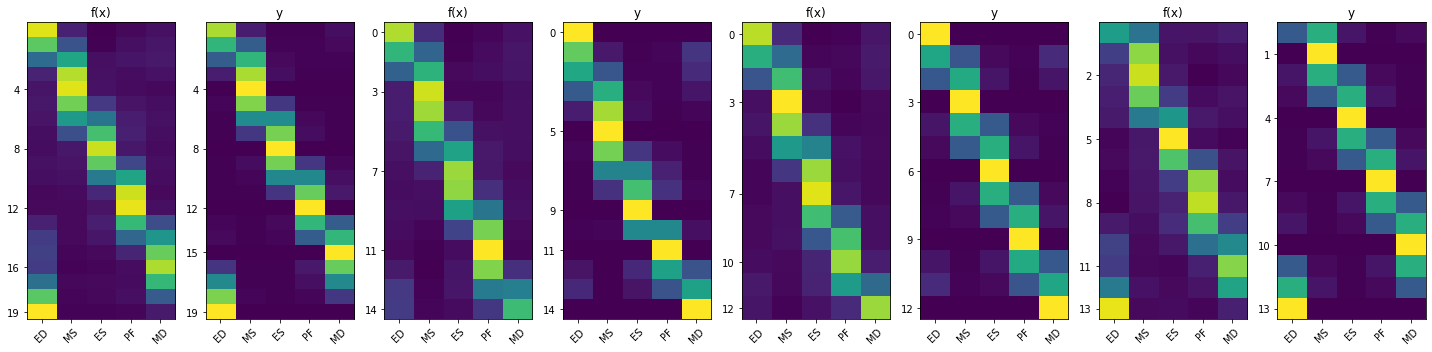

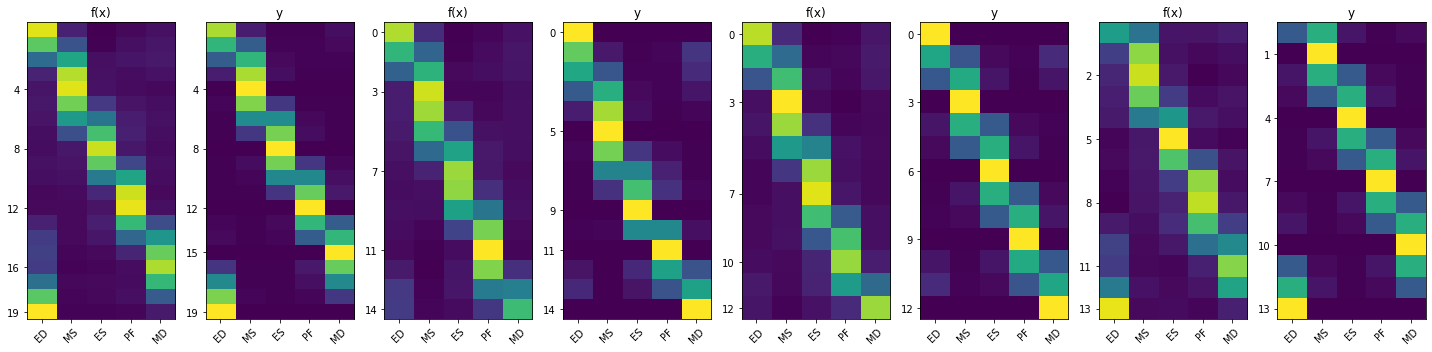

In [33]:
from src.visualization.Visualize import show_phases

show_phases(outputs,pred)

In [34]:
# calculate the meandiff score for one batch
from src.utils.Metrics import meandiff
score_fn = meandiff
score_fn(outputs, pred).numpy()

[[19  4  8 12 15]
 [ 0  5  9 11 14]
 [ 0  3  6  9 12]
 [13  1  4  7 10]]
msk shape : (4, 36, 5)
(4, 5)
(5,)
(5,)
(5,)
(5,)


2.5

In [21]:
def get_min_distance(a,b,mod):
    decr_counter = 0
    incr_counter = 0
    
    smaller = min(a,b)
    bigger = max(a,b)

    res = list(range(mod))
    print(res)
    i1 =bigger
    while(res[i1]!=smaller):
        decr_counter = decr_counter+1
        i1 = i1-1

    i1 = bigger
    while(res[i1]!=smaller):
        incr_counter = incr_counter+1
        i1 = (i1+1)%mod

    return min(decr_counter, incr_counter)
    
    
get_min_distance(4,18,19)
    

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


5

In [36]:
# calculate the meandiff score for all batches
scores = []
for batch in validation_generator:
    x,y = batch
    p = model(x)
    scores.append(score_fn(y,p))
scores

[<tf.Tensor: shape=(), dtype=float32, numpy=3.25>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.25>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.5>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.25>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.5>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.75>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.25>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.25>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.25>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.5>]

In [37]:
tf.reduce_mean(scores).numpy()

2.375

# Generator tests

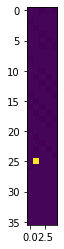

In [9]:
temp = outputs[2][:]
plt.imshow(temp)

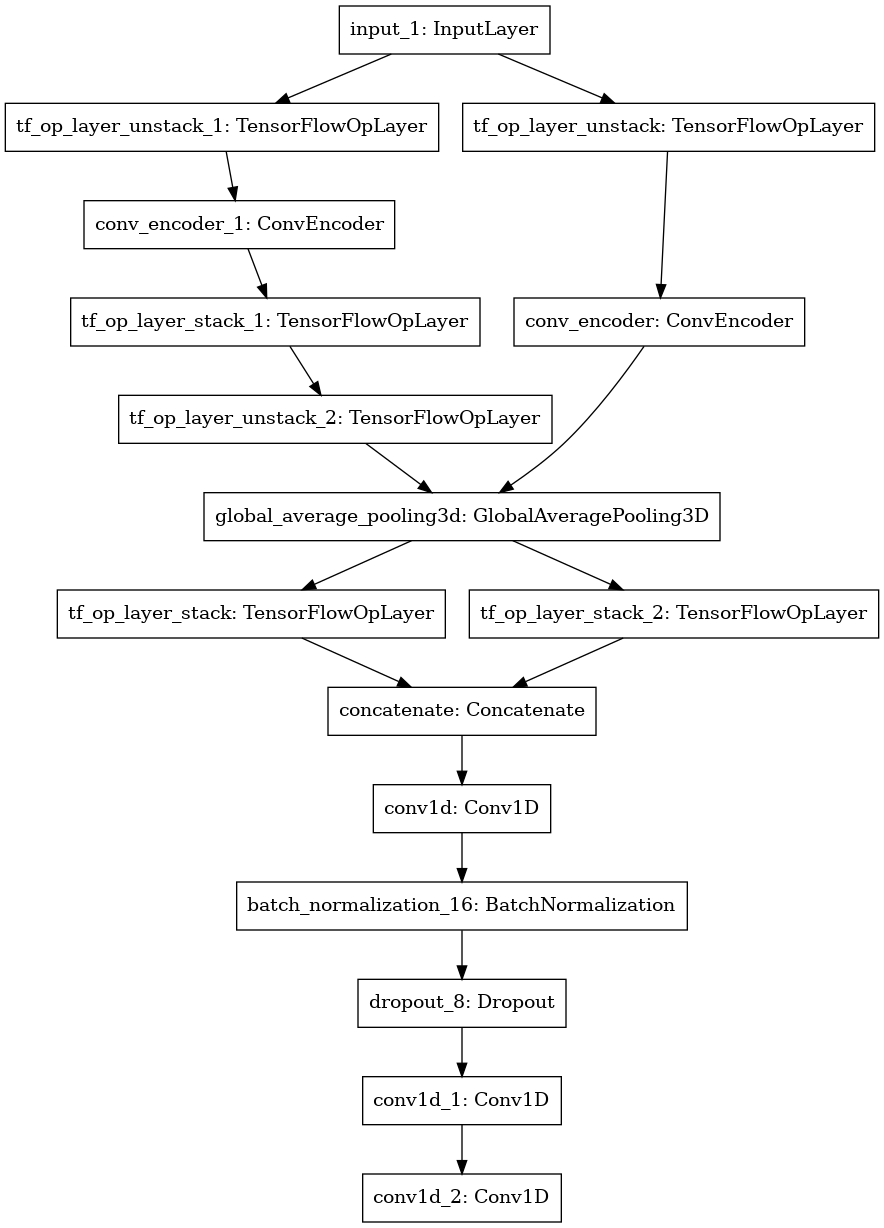

In [16]:
tf.keras.utils.plot_model(
    model, show_shapes=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96
)

In [11]:
temp = outputs[2][:]
print(temp.shape)
print(temp)
print('axis = 0: {}'.format(temp.sum(axis=0)))
print('axis = 1: {}'.format(temp.sum(axis=1)))


(36, 5)
[[ 1.38348091e+00  1.23632700e+34 -1.81182511e+36  4.56599092e-41
  -1.81926115e+36]
 [ 4.56599092e-41  3.22819804e-03 -6.46831612e-31 -2.99579847e-29
   4.56613105e-41]
 [-1.81928397e+36  4.56599092e-41  6.13270337e-11 -2.39915704e+10
  -2.78123062e-29]
 [ 4.56613105e-41 -1.81930679e+36  4.56599092e-41  1.01344287e+04
   8.43546880e+07]
 [-1.99690347e-16  4.56613105e-41 -1.81932961e+36  4.56599092e-41
  -4.54529307e+33]
 [-6.16835742e+04 -1.04216684e-17  4.56613105e-41 -1.81935242e+36
   4.56599092e-41]
 [-2.90389409e-07 -6.48057959e+03 -1.81197723e+36  4.56599092e-41
  -1.81937524e+36]
 [ 4.56599092e-41 -4.12825109e+26  4.77408846e-17 -1.38908956e-16
   4.56613105e-41]
 [-1.81939806e+36  4.56599092e-41 -1.45753474e+18 -2.60766018e-02
  -1.38886934e-16]
 [ 4.56613105e-41 -1.33684881e-16  4.56613105e-41 -9.35618770e-27
   7.34581107e-15]
 [-1.97438086e-16  4.56613105e-41 -1.81944369e+36  4.56599092e-41
   2.14501761e-05]
 [ 1.19029230e-17 -1.81186568e+36  4.56599092e-41 -1.8194

In [22]:
lst = [1,2,3,4,5,6,7,8,9]
first = lst[3:]
first.extend(lst[:3])
first

[4, 5, 6, 7, 8, 9, 1, 2, 3]

In [ ]:
onehot = np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]])

In [ ]:
onehot.shape

In [ ]:
onehot_t = onehot.T
onehot_t.shape
onehot_t

In [ ]:
print(np.argmax(onehot, axis=1))
print(np.argmax(onehot_t, axis=0))

In [ ]:
# iterate over the phases j
# linspace from i to i+1 from indices
temp = onehot_t[:,0].astype(float)
i = 0
j = 3 + 1
temp[i:j] = np.linspace(i,j,j-i)
temp

In [ ]:
onehot_t = onehot_t.astype(float)
indices = np.argmax(onehot_t, axis=0)
for i in range(onehot_t.shape[1]) :
    start = indices[i]
    # make it a ring
    second = (i+1)%len(indices)
    end = indices[second]
    onehot_t[start:end,i] = np.linspace(1,0,int(end-start))
onehot_t
             
    

In [ ]:
plt.imshow(temp)

In [ ]:
plt.imshow(temp.T)

In [ ]:
%%timeit
temp.mean()

In [ ]:
%%timeit
np.mean(temp)

In [ ]:
np.linspace(-1,1,10)